# Modeling

## Introduction

In this notebook, we finally get to explore some machine learning models in attempt to predict baseball pitch types. We have wrangled, explored, and processed Statcast data resulting in 3 datasets available for modeling:

- no_pitchers - All pitches without pitcher reference
- pitchers - All pitches with reference to top 5 pitchers based on pitch count
- first_pitch - Only the first pitch in each at-bat without pitcher reference

From here, we can explore modeling various scenarios with the data above. We'll begin by setting a baseline from predicting all pitches as the most common pitch type, FF. Our modeling efforts will include scaling the data, creating a train/test split, and evaluating performance metrics. We will also complete tuning of some hyperparameters relevant to each model. After creating a baseline prediction using sklearn's DummyClassifier, we'll work with a Decision Tree and Random Forest.

## Imports and Data Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree, metrics
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline, Pipeline

In [2]:
no_pitchers = pd.read_csv('no_pitchers.csv')
pitchers = pd.read_csv('pitchers.csv')
first_pitch = pd.read_csv('first_pitch.csv')

Given that we have split the data we've been working with, let's check to make sure we have enough observations (pitches) within each dataset.

In [3]:
print(no_pitchers.shape)
print(pitchers.shape)
print(first_pitch.shape)

(110301, 26)
(3114, 31)
(28166, 26)


We have plenty of pitches to work with. The 5 extra features in the 'pitchers' dataset are the 5 pitchers we kept and encoded.

## Train/Test Split

We begin with our first_pitch dataset containing only the first pitch of each at-bat in a given game.

In [4]:
first_pitch.head().T

,0,1,2,3,4
pitch_type,SL,FF,FF,SL,FF
balls,0,0,0,0,0
strikes,0,0,0,0,0
on_3b,0,0,0,0,0
on_2b,1,1,1,1,0
on_1b,1,0,0,0,1
outs_when_up,2,2,2,1,0
inning,9,9,9,9,9
at_bat_number,77,76,75,74,73
pitch_number,1,1,1,1,1


## But first, some data wrangling/EDA during modeling!?

That's right folks. The data science process is non-linear despite our attempts to organize it as such. The classification reports in later steps of this notebook have helped to expose a couple pitch types of concern. The counts of "EP" and "KN" pitch types are very low and may cause issues when performing cross-validation. We will address this by dropping the respective pitch types from the data.

In [5]:
first_pitch.drop(first_pitch[first_pitch['pitch_type'].isin(['EP', 'KN'])].index, inplace=True)
pitchers.drop(pitchers[pitchers['pitch_type'].isin(['EP', 'KN'])].index, inplace=True)
no_pitchers.drop(no_pitchers[no_pitchers['pitch_type'].isin(['EP', 'KN'])].index, inplace=True)

Let's define X and y, then check the partition sizes if we use a 70/30 train/test split.

In [6]:
X = first_pitch.drop(columns='pitch_type')
y = first_pitch['pitch_type']

In [7]:
len(first_pitch) * .7, len(first_pitch) * .3

(19705.0, 8445.0)

In [8]:
#Creating train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
X_train.shape, X_test.shape

((19705, 25), (8445, 25))

In [10]:
y_train.shape, y_test.shape

((19705,), (8445,))

The shape of our train/test split aligns with expectations for a 70/30 train/test split. Let's check to make sure all or our features are of numeric type.

In [11]:
X_train.dtypes

balls                                   int64
strikes                                 int64
on_3b                                   int64
on_2b                                   int64
on_1b                                   int64
outs_when_up                            int64
inning                                  int64
at_bat_number                           int64
pitch_number                            int64
home_score                              int64
away_score                              int64
bat_score                               int64
fld_score                               int64
stand_L                                 int64
stand_R                                 int64
p_throws_L                              int64
p_throws_R                              int64
inning_topbot_Bot                       int64
inning_topbot_Top                       int64
if_fielding_alignment_Infield shift     int64
if_fielding_alignment_Standard          int64
if_fielding_alignment_Strategic   

In [12]:
X_test.dtypes

balls                                   int64
strikes                                 int64
on_3b                                   int64
on_2b                                   int64
on_1b                                   int64
outs_when_up                            int64
inning                                  int64
at_bat_number                           int64
pitch_number                            int64
home_score                              int64
away_score                              int64
bat_score                               int64
fld_score                               int64
stand_L                                 int64
stand_R                                 int64
p_throws_L                              int64
p_throws_R                              int64
inning_topbot_Bot                       int64
inning_topbot_Top                       int64
if_fielding_alignment_Infield shift     int64
if_fielding_alignment_Standard          int64
if_fielding_alignment_Strategic   

## Baseline
We begin with our baseline of predicting the most frequent pitch type (FF) for all pitches. Sklearn's DummyClassifier allows us to easily accomplish this.

In [13]:
dumb_class = DummyClassifier(strategy='constant', constant='FF')
dumb_class.fit(X_train, y_train)
dumb_class.constant

'FF'

In [14]:
#Confirming our predictions for the DummyClassifier are all 'FF'
y_train_pred = dumb_class.predict(X_test)
print(y_train_pred[:5])

['FF' 'FF' 'FF' 'FF' 'FF']


In [15]:
print(classification_report(y_test, y_train_pred, zero_division=0))

              precision    recall  f1-score   support

          CH       0.00      0.00      0.00       628
          CU       0.00      0.00      0.00       865
          FC       0.00      0.00      0.00       512
          FF       0.38      1.00      0.55      3204
          FS       0.00      0.00      0.00        66
          FT       0.00      0.00      0.00       812
          KC       0.00      0.00      0.00       186
          SI       0.00      0.00      0.00       771
          SL       0.00      0.00      0.00      1401

    accuracy                           0.38      8445
   macro avg       0.04      0.11      0.06      8445
weighted avg       0.14      0.38      0.21      8445



In [16]:
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test, y_train_pred))

Balanced Accuracy: 0.1111111111111111


The classification report confirms our dummy classification model predicted only FF as it's the only class with non-zero values. The report also confirms FF is the most frequent pitch type as its support value is the largest. Both the precision and recall for FF are as expected given the accuracy of our positive predictions for FF, precision, should be equal to the ratio of FF to all, and our recall, or the percent of positives we predicted accurately, should be 100% or 1.0.

Due to the nature of the unbalanced classes in our multivariate classification problem, we will be focused on the balanced accuracy score for performance measurement of our models in addition to class specific performance. We're starting with a low bar of 0.11 for balanced accuracy. The standard accuracy of 0.38 alone is misleading because it doesn't reflect our inability to predict any class other than 'FF'. Let's move on to our first real model using sklearn's DecisionTreeClassifier.

## Decision Tree

Now that we have a baseline for comparison, let's move on by exploring a decision tree model. We'll begin with a tree using default parameter settings then move to explore the class_weight setting before tuning some parameters. Given a decision tree's tendancy to overfit, we will focus on pruning our tree with parameters such as max_depth and max_leaf_nodes. We also want to evaluate the resources required for each model by measuring the time it takes to run a model.

In [17]:
%%time
#Default option: class_weight = none
#All classes are weighted evenly, so the model is considering individual errors of each prediction to be equally important. 
#This isn't great with inbalanced classes because the larger classes being predicted accurately will naturally happen more 
#often because there is more data there.

default_tree = tree.DecisionTreeClassifier()
default_tree.fit(X_train, y_train) 
default_pred = default_tree.predict(X_test)
print(classification_report(y_test, default_pred))
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test, default_pred))

              precision    recall  f1-score   support

          CH       0.13      0.15      0.14       628
          CU       0.13      0.14      0.13       865
          FC       0.09      0.09      0.09       512
          FF       0.43      0.44      0.43      3204
          FS       0.04      0.05      0.04        66
          FT       0.12      0.11      0.12       812
          KC       0.03      0.04      0.04       186
          SI       0.16      0.13      0.15       771
          SL       0.22      0.20      0.21      1401

    accuracy                           0.25      8445
   macro avg       0.15      0.15      0.15      8445
weighted avg       0.25      0.25      0.25      8445

Balanced Accuracy: 0.14993031927056527
Wall time: 312 ms


Great! We already see an improvement on the accuracy with our default decision tree model. Our class level predictions are also improved as we're now correctly guessing pitch types in addition to FF. Yes, our recall for FF has been cut in half but in exchange for an overall improvement to our model. Let's do the same for a couple additional class_weight settings.

In [18]:
%%time
#Balanced classes: class_weight = balanced
#The classes are weighted according to the inverse of their frequency. This class weighting is better for highly inbalanced 
#classes because the errors made in the smaller classes are penalized more heavily than the errors made in the larger 
#classes. 

balanced_tree = tree.DecisionTreeClassifier(class_weight = 'balanced')
balanced_tree.fit(X_train, y_train) 
balanced_pred = balanced_tree.predict(X_test)
print(classification_report(y_test, balanced_pred, zero_division=0))
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test, balanced_pred))

              precision    recall  f1-score   support

          CH       0.13      0.15      0.14       628
          CU       0.14      0.13      0.14       865
          FC       0.11      0.13      0.12       512
          FF       0.40      0.34      0.37      3204
          FS       0.05      0.08      0.06        66
          FT       0.11      0.14      0.12       812
          KC       0.05      0.08      0.06       186
          SI       0.14      0.15      0.15       771
          SL       0.22      0.21      0.22      1401

    accuracy                           0.23      8445
   macro avg       0.15      0.16      0.15      8445
weighted avg       0.24      0.23      0.23      8445

Balanced Accuracy: 0.15641572862175776
Wall time: 351 ms


Decision trees don't naturally perform well on imbalanced datasets, especially when there are multiple classes to classify. Changing the class_weight to "balanced" had a minimal effect on the balanced accuracy but it improved our class level predictions. This is due to shifting the weight from FF to other classes less representative in the data. While our FF performance declined, we see an improvement in classes like FC and FT. We accomplished this without any detrement to the resources required to run our model.

In [19]:
%%time
#Manual assignments to the classes - class weight = dictionary 
#Say a given batter has a lot of trouble hitting pitches categorized as "SL". We are going to weight that class more
#heavily than the other classes because we want to model to be especially accurate with that class. In other words, when 
#the model is splitting at the nodes, we want it to most heavily penalize incorrect predictions for the "SL" class. 
#We have given the "SL" class twice the weight as any other class.

#Creating the weighting dictionary
pitches = y_train.unique().tolist()
weights = [1] * len(pitches)
pitch_weight_dict = dict(zip(pitches, [1] * len(pitches)))
pitch_weight_dict['SL'] = 2

weighted_tree = tree.DecisionTreeClassifier(class_weight = pitch_weight_dict)
weighted_tree.fit(X_train, y_train) 
weighted_pred = weighted_tree.predict(X_test)
print(classification_report(y_test, weighted_pred, zero_division=0))
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test, weighted_pred))

              precision    recall  f1-score   support

          CH       0.14      0.15      0.15       628
          CU       0.13      0.14      0.14       865
          FC       0.10      0.10      0.10       512
          FF       0.42      0.42      0.42      3204
          FS       0.03      0.03      0.03        66
          FT       0.13      0.12      0.12       812
          KC       0.05      0.05      0.05       186
          SI       0.15      0.12      0.13       771
          SL       0.21      0.22      0.22      1401

    accuracy                           0.25      8445
   macro avg       0.15      0.15      0.15      8445
weighted avg       0.25      0.25      0.25      8445

Balanced Accuracy: 0.1514916585685209
Wall time: 326 ms


Manually assigning our class weights does not result in meaningful improvement to our model. Given the count of classes to predict and the significance of the imbalance, using the setting of 'balanced' class_weight is our best choice. We can now move on to tuning some hyperparameters with our decision tree model's class_weight set to 'balanced'.

## Tree Visualization

Let's try to visualize our balanced tree. The initial attempt required a kernel interruption due to the size and complexity of our tree. Our decision tree is splitting until leaf nodes have a purity of 0, and with 11 pitch types (target variable) and 25 features, this will create a tree too large to visualize and one that is almost certainly overfitting. Later, we will tune some hyperparameters with the intent to reduce the likliness of overfitting.

In [20]:
print("Tree Depth:", balanced_tree.get_depth())
print("# of Leaves:", balanced_tree.get_n_leaves())

Tree Depth: 33
# of Leaves: 12585


A tree depth of 33 with over 12k leaves confirms it is too large to visualize without pruning. We can prune the tree for visualization by setting the max_depth within plot_tree. 

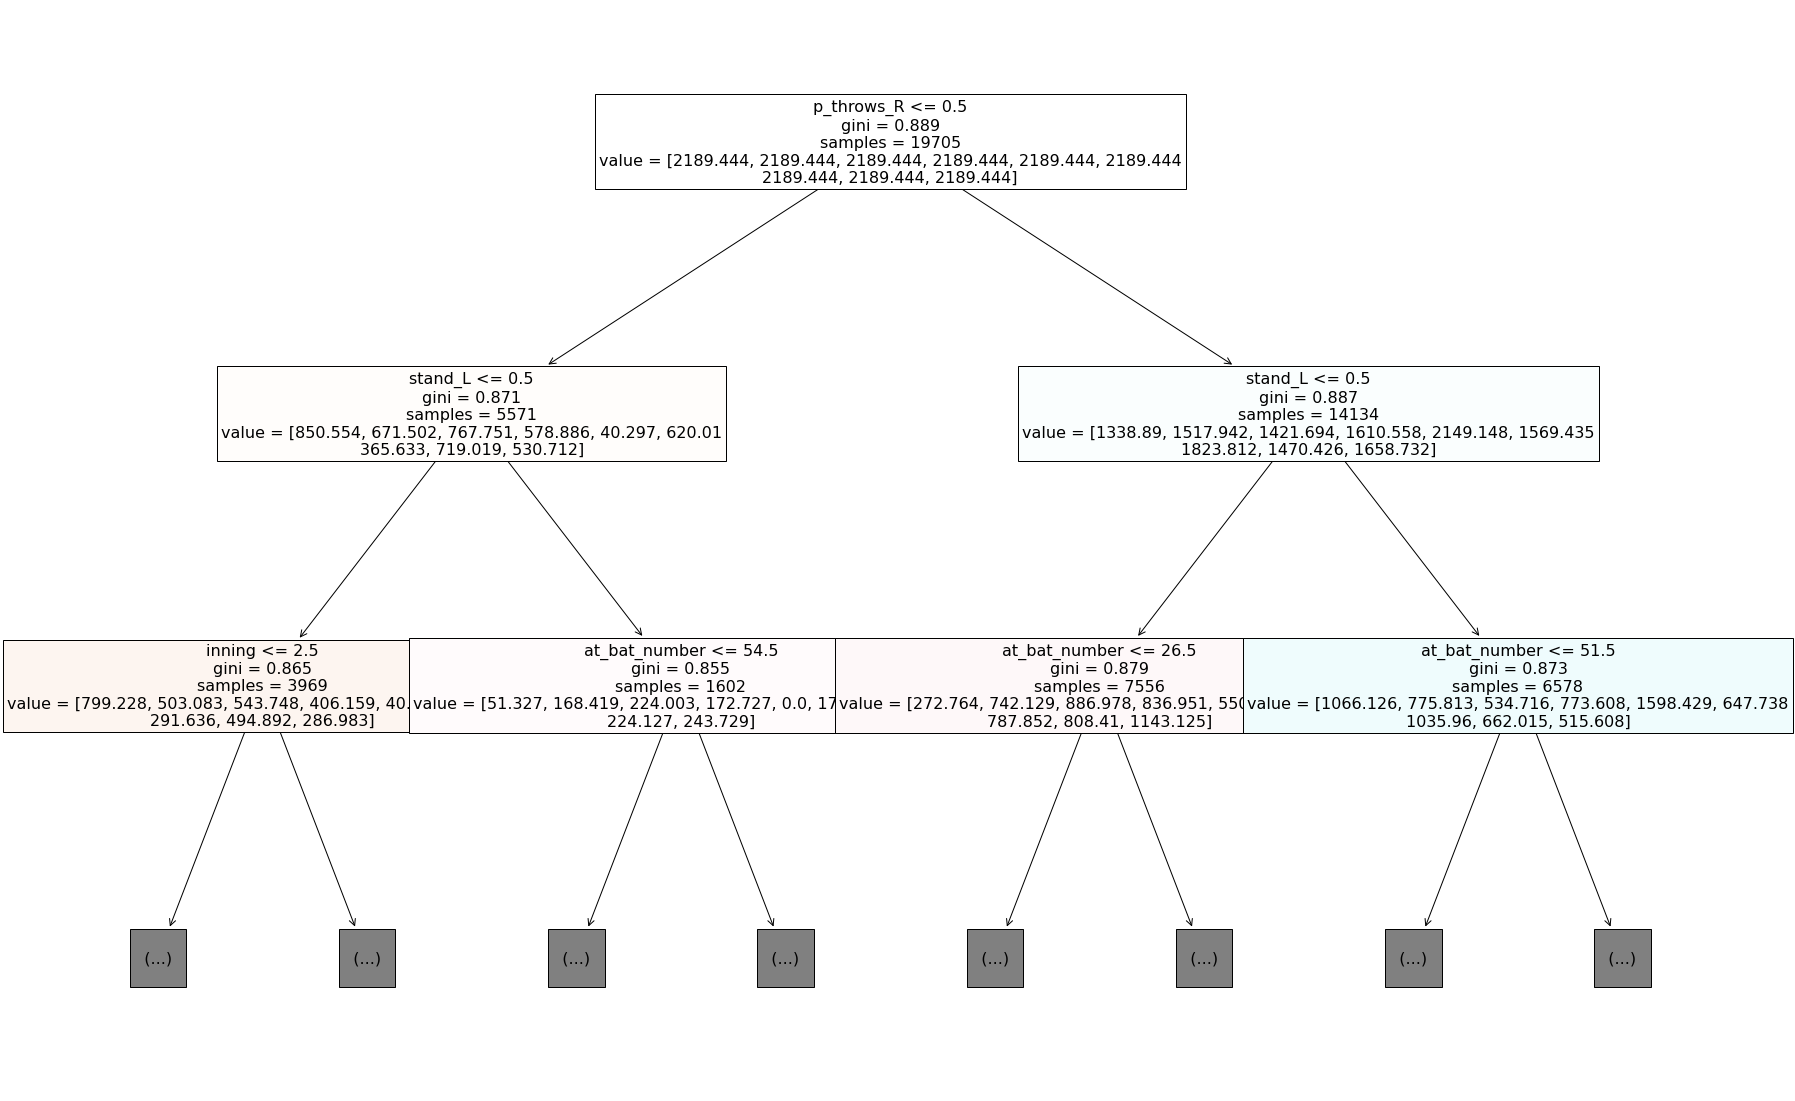

In [21]:
fig = plt.figure(figsize=(30,20))
tree.plot_tree(balanced_tree, 
                   feature_names=X_train.columns,  
                   max_depth=2,
                   fontsize=16,
                   filled=True);

This model has determined one of the most important features to be the one that designates which hand the pitcher throws with given the tree's root node is the p_throws_R. This is not surprising. Pitcher and hitter substitutions are often made based on which hand the pitcher throws with AND which hand the batter bats with. We see the model recognizes both with depth 1 nodes addressing the batter's stance position. From there, depth 2 is almost entirely based on at_bat_number. The one other feature is inning and both are a measure of the game's progression. 

This is intuitive to me as it makes sense to first ask, who's pitching (left or right-handed), who's hitting (left or right-handed), and when is the at-bat (at-bat number or inning). We can see this tree is just getting started because the nodes are far from pure with gini values above 0.85. The splits are nice and balanced but results in the need for further seperation. 

## Same Model, Different Data

Before we tune some hyperparameters, I want to use our other datasets to see if we can do better with predicting pitch types in different scenarios. The first model is looking at the first pitch only without reference to pitcher. The next 2 will consider all pitches with and without pitcher reference. First, let's keep pitcher reference out and consider all pitches.

In [22]:
X = no_pitchers.drop(columns='pitch_type')
y = no_pitchers['pitch_type']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3, random_state=42)

balanced_tree2 = tree.DecisionTreeClassifier(class_weight = 'balanced')
balanced_tree2.fit(X_train2, y_train2) 
balanced_pred2 = balanced_tree2.predict(X_test2)
print(classification_report(y_test2, balanced_pred2, zero_division=0))
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test2, balanced_pred2))

              precision    recall  f1-score   support

          CH       0.21      0.20      0.20      3777
          CU       0.16      0.18      0.17      2789
          FC       0.20      0.23      0.22      2167
          FF       0.43      0.38      0.40     11950
          FO       0.03      0.20      0.05         5
          FS       0.16      0.22      0.19       451
          FT       0.20      0.22      0.21      2887
          KC       0.12      0.17      0.14       759
          SI       0.28      0.31      0.30      2474
          SL       0.28      0.27      0.27      5815

    accuracy                           0.29     33074
   macro avg       0.21      0.24      0.21     33074
weighted avg       0.30      0.29      0.29     33074

Balanced Accuracy: 0.23756177472717727


Much improved! Our model is better at predicting pitch_types when we consider more than just the first pitch of an at-bat. I suspect this is due to the lack of variety as pitch counts increase within a given at-bat. It also allows the pitcher's rhythm to be discovered and if he has any tendencies to throw a certain pitch type at a given point in the at-bat. Finally, let's see how a decision tree model performs when we add a reference to the pitcher:

In [23]:
X = pitchers.drop(columns='pitch_type')
y = pitchers['pitch_type']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.3, random_state=42)

balanced_tree3 = tree.DecisionTreeClassifier(class_weight = 'balanced')
balanced_tree3.fit(X_train3, y_train3) 
balanced_pred3 = balanced_tree3.predict(X_test3)
print(classification_report(y_test3, balanced_pred3, zero_division=0))
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test3, balanced_pred3))

              precision    recall  f1-score   support

          CH       0.14      0.16      0.15        89
          CU       0.22      0.20      0.21        55
          FC       0.35      0.40      0.37        70
          FF       0.33      0.32      0.33       220
          FT       0.49      0.53      0.51       180
          KC       0.40      0.38      0.39       114
          SI       0.13      0.13      0.13        30
          SL       0.40      0.36      0.38       177

    accuracy                           0.35       935
   macro avg       0.31      0.31      0.31       935
weighted avg       0.35      0.35      0.35       935

Balanced Accuracy: 0.30928336755885893


Even better!! Now the model can recognize when a specific pitcher is pitching and how that affects the potential for pitch type. Not all pitchers throw all pitch types. In fact, some pitchers may have only 2 or 3 different options. Applying the use of a model like this in a game would be more beneficial if we built them by pitcher with years of historical pitch data. 

For now, we'll work with this approach. Let's see what we can learn from visualizing the tree:

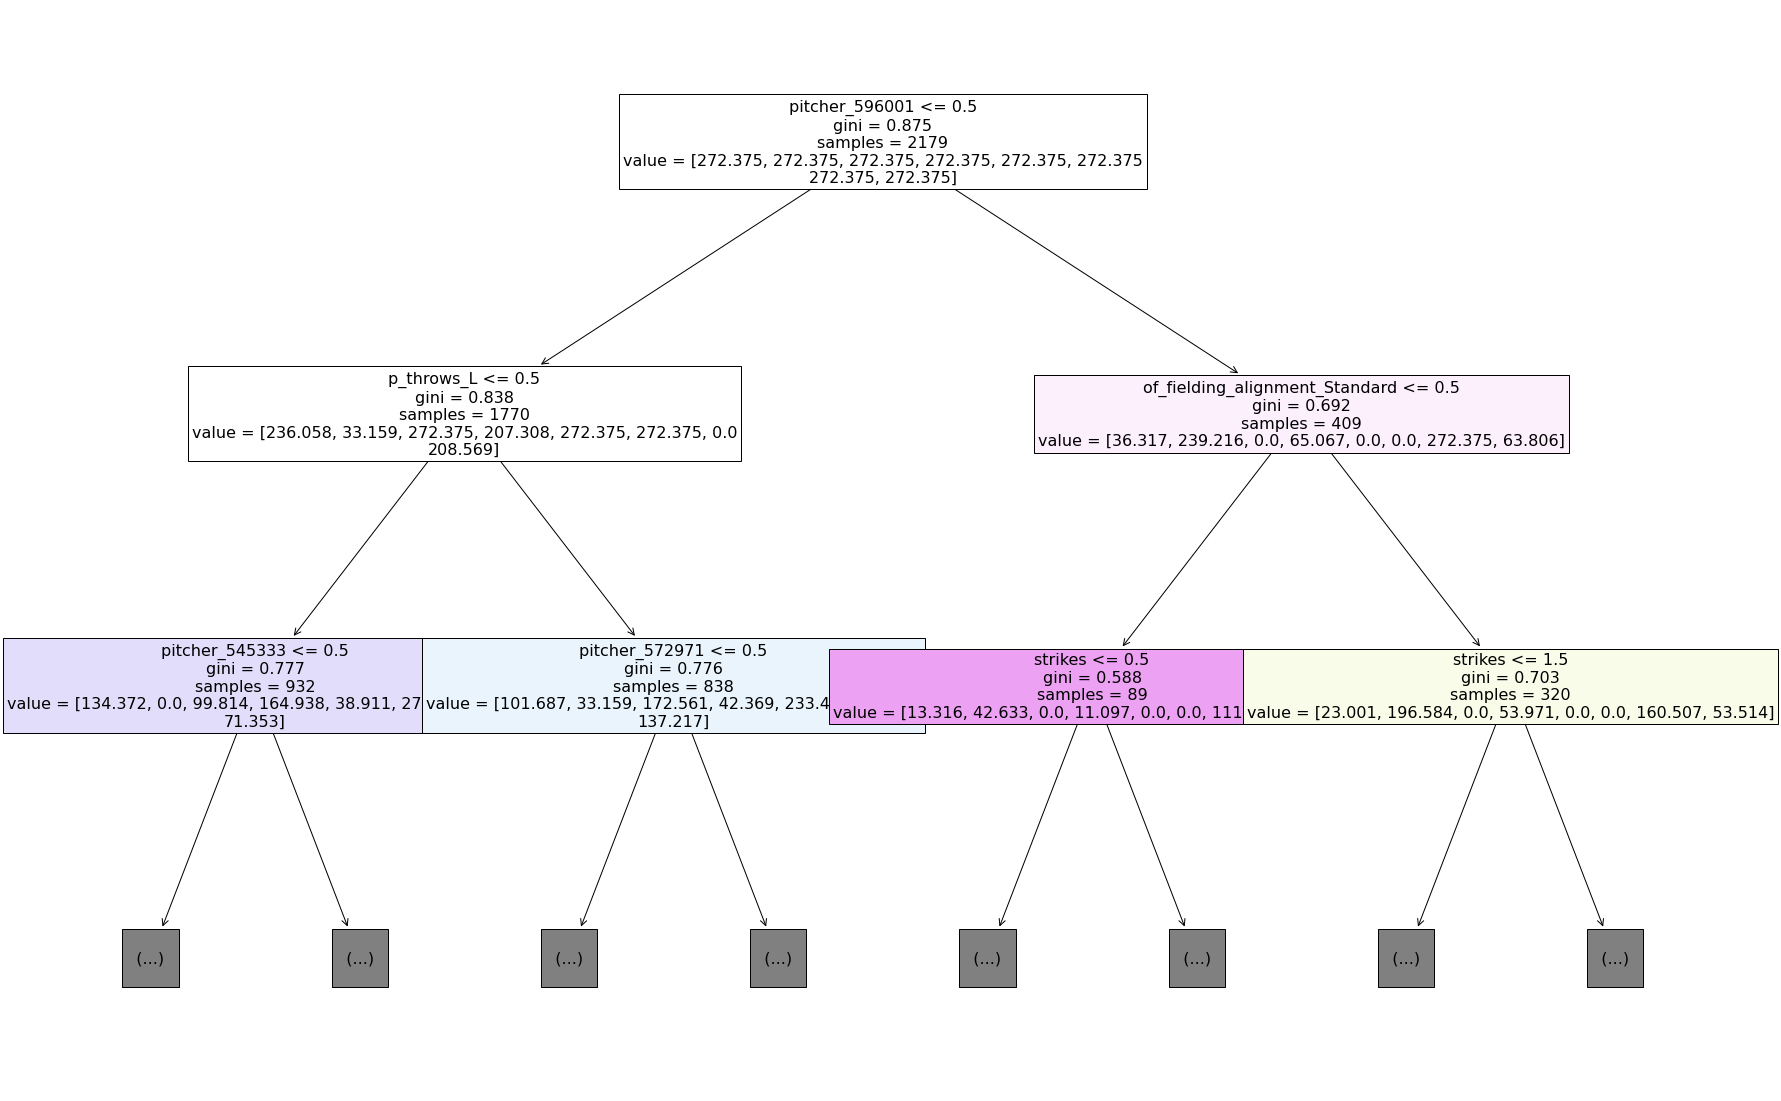

In [24]:
fig = plt.figure(figsize=(30,20))
tree.plot_tree(balanced_tree3, 
                   feature_names=X_train3.columns,  
                   max_depth=2,
                   fontsize=16,
                   filled=True);

Well look at that! The model is doing exactly that in using the pitcher identifiers in the root node and 2 of the 4 nodes in level 2. 

## Hyperparameter Tuning

Decision Trees are prone to overfit on datasets with a large number of features. One parameter we can use to help prevent overfitting is the max_depth setting. We can also use min_weight_fraction_leaf (instead of min_samples_split which doesn't pay attention to the class weights). There are 2 purity methods for us to explore as well, gini and entropy. Decision Trees don't care if the data is scaled or not, so we won't build a pipeline that accomplishes such.

In [25]:
decision_tree = tree.DecisionTreeClassifier(class_weight = 'balanced')
decision_tree.fit(X_train3, y_train3) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [26]:
#The value of our GridSearch parameter will be a list that contains a Python dictionary. The keys will be parameters we
#want to tune and the values will be thier respective range of values.

params = {
    'criterion':['gini', 'entropy'],
    'max_depth':[5,10,15,25,None],
    'min_weight_fraction_leaf':[0.0,0.05,0.10,0.20,0.50],
    'max_features':[5,10,15,20,None]}

In [27]:
grid = GridSearchCV(decision_tree, param_grid=params, cv=5)

In [28]:
grid.fit(X_train3, y_train3)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'

In [29]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'min_weight_fraction_leaf': 0.0}

We now have the parameter settings we'll use in our decision tree model to be fit with the full training set. Then we can proceed with using the model to predict our test set and evaluate model performance from there.

In [30]:
%%time
clf = tree.DecisionTreeClassifier(class_weight='balanced', 
                                     criterion='gini',
                                     max_depth=5,
                                     max_features=20,
                                     min_weight_fraction_leaf=0.0)
clf.fit(X_train3, y_train3) 
y_pred = clf.predict(X_test3)
print(classification_report(y_test3, y_pred, zero_division=0))
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test3, y_pred))

              precision    recall  f1-score   support

          CH       0.00      0.00      0.00        89
          CU       0.25      0.51      0.34        55
          FC       0.27      0.93      0.41        70
          FF       0.47      0.03      0.06       220
          FT       0.46      0.36      0.40       180
          KC       0.44      0.73      0.55       114
          SI       0.19      0.33      0.24        30
          SL       0.46      0.48      0.47       177

    accuracy                           0.37       935
   macro avg       0.32      0.42      0.31       935
weighted avg       0.38      0.37      0.31       935

Balanced Accuracy: 0.4208331965635712
Wall time: 76.9 ms


A balanced accuracy of 43%!! We accomplished an improvement in performance while reducing runtime resources from 310 to 36ms. In an attempt to reduce overfitting, we want to stop growing the trees earlier. We did this above by setting max_depth=5 as suggested by our parameters grid search. Next, we will try a random forest because they aggregate many decision trees to limit overfitting as well as error due to bias.

## Random Forest
Let's see if an ensemble method for decision trees can help improve our model performance. We will use a RandomForestClassifier within a pipeline that is also scaling the data, in addition to cross-validation and grid search for hyperparameter tuning.

In [31]:
#We begin by defining the pipeline as mentioned above
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=42))

In [32]:
#Now we can use the pipeline wihtin our cross-validation efforts
rf_default_cv_results = cross_validate(RF_pipe, X_train3, y_train3, cv=5)

In [33]:
#Printing the results of our cross-validation
print(rf_default_cv_results)

{'fit_time': array([0.79958916, 0.8236475 , 0.81477451, 0.79776025, 0.81065702]), 'score_time': array([0.04685855, 0.04686141, 0.04729724, 0.04723191, 0.04687309]), 'test_score': array([0.36238532, 0.36926606, 0.36697248, 0.35321101, 0.42758621])}


In [34]:
#Looking at just the array for our test_scores from cross_validate
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.36238532, 0.36926606, 0.36697248, 0.35321101, 0.42758621])

In [35]:
#Calculating the mean and standard deviation for the array of scores
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.3758842138563746, 0.026429564806096397)

One of the parameters to tune in our Random Forest is the number of Decision Trees used (n_estimators) in our ensemble. We can also decide if we should use the StandardScaler by provide an option of 'None' in the grid parameters for GridSearchCV.

In [36]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestclassifier__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
}
grid_params

{'randomforestclassifier__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(copy=True, with_mean=True, with_std=True),
  None]}

In [37]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train3, y_train3)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                   

Now we can print the best parameters selected in our cross-validation GridSearch. We find that the best value for n_estimators is 379 and we should use the StandardScaler.

In [38]:
rf_grid_cv.best_params_

{'randomforestclassifier__n_estimators': 379,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [39]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train3, y_train3, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.36009174, 0.36009174, 0.37385321, 0.39220183, 0.42298851])

In [40]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.38184540757144364, 0.023707927593158595)

We saw the challenge with visualizing a single decision tree of this nature, so we need to consider a different approach for visualizing hundreds or thousands of trees in a Random Forest. One way for us to gain insight into the Random Forest is for us to view a plot of feature importance determined by the model.

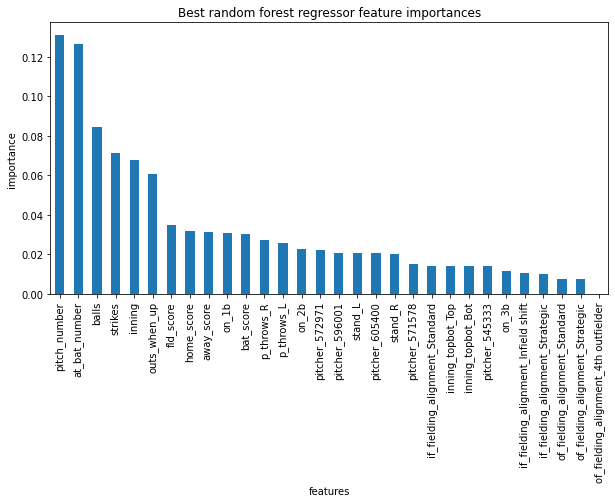

In [41]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestclassifier.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train3.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

Similar to the single Decision Tree models, we notice the Random Forest finds importance in the progression of the game as measured by pitch_number and at_bat_number. One noticable difference is how little importance the forest gives to which hand the pitcher throws with and which pitcher is throwing. 

Now that we have confirmed the use of the StandardScaler and identified the best value for n_estimators, let's combine those with the previously determined parameters from our Decision Tree grid search.

In [42]:
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(class_weight='balanced', 
                                     criterion='gini',
                                     max_depth=5,
                                     max_features=20,
                                     n_estimators=379))

We fit the training data to the pipeline created above.

In [43]:
RF_pipe.fit(X_train3, y_train3)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=5,
                                        max_features=20, max_leaf_nodes=None,
                                        max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=379, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, 

Now we can predict our pitch types with the test data and evaluate our Random Forest model.

In [44]:
y_pred = RF_pipe.predict(X_test3)

In [45]:
print(classification_report(y_test3, y_pred, zero_division=0))

              precision    recall  f1-score   support

          CH       0.00      0.00      0.00        89
          CU       0.26      0.49      0.34        55
          FC       0.29      0.84      0.43        70
          FF       0.50      0.01      0.02       220
          FT       0.49      0.36      0.41       180
          KC       0.42      0.89      0.57       114
          SI       0.18      0.40      0.24        30
          SL       0.48      0.49      0.48       177

    accuracy                           0.38       935
   macro avg       0.33      0.43      0.31       935
weighted avg       0.40      0.38      0.30       935



Our Random Forest did not perform significantly better than our Decision Tree. Given the loss of our ability to interpret the results, it doesn't make sense for us to use the Random Forest.

## Conclusion

We began our modeling efforts with the ideal of accurately predicting MLB pitch types. At a minimum, we hoped to determine features of importance when attempting to predict pitch type. Any insights gained could help better understand what pitch might be coming next during a major league at-bat. Through this process, we have found some interesting information that guides the steps ahead in better prediction of pitch types. 

In the beginning, we used a DummyClassifier to get a sense of how poorly a model would perform if it predicted FF for every first pitch thrown at a batter. We saw improvement in model performance if we used a default Decision Tree for the first pitch data. We visualized this tree to find the model valued pitch hand and batter stance in addition to the progression of the at-bat and game. As we introduced more pitches and another feature, our models improved even more. 

Finally, after tuning hyperparamters for our Decision Tree, we went on to do the same for a Random Forest pipeline. Our Random Forest found the features for pitch_number and at_bat number to be of greatest importance. In the end, the model performance of our forest did not meaningfully outperform the best tree. We did gain the insight to look more into the count of balls and strikes and how that might affect pitch type. The models here have not given us a secret weapon in knowing what to expect when a pitch is being thrown, but they have provided meaningful insights into what to consider when looking to predict pitch type.